# Investigate drop in mobile VE edit completion rate among unregistered users

[Task](https://phabricator.wikimedia.org/T237075)


## Overview ##

Around July 4, 2019, there was a drop in the edit completion rate among unregistered users attempting to edit using mobile VE. 

One potential explanation for the drop is the start of the VisualEditor as default A/B testing. The start of the A/B test would have likely caused a greater number of unregistered, and potentially lower intent users, to open the mobile VisualEditor as a result of it becoming the default editor for 50% of contributors on the 20 wikis participating in the test

**Timeline**
28-June-2019: Mobile VE is set as the default editor for 50% of contributors to the 20 participating wikis
Around this same time, we start to see a decline in edit completion rate among unregistered users [5]
4-July-2019: Decline in edit completion rate among unregistered contributors accelerates


Notes:
We consider any session that reaches the ready event as an attempt, to filter out what seems to be a large number of bot inits (https://phabricator.wikimedia.org/T209995).
 

Another, less urgent issue I noticed is that we're logging all mobile VE events, but only 1/16 mobile wikitext events. This means we're throwing away a lot of data and reducing our statistical power. Luckily, @DLynch thinks it will be easy to turn on that oversampling.

## Investigation Plan ##

Confirm if the below happened during this same ~28 June – ~15 July time period:

* The number of unregistered users attempting to make edits using the mobile wikitext editor declined
* The number of unregistered users attempting to make edits using the mobile VisualEditor increased

In [12]:
shhh <- function(expr) suppressPackageStartupMessages(suppressWarnings(suppressMessages(expr)))
shhh({
   library(tidyverse); library(glue); library(lubridate); library(scales); library(zoo)
})

In [111]:
query <- 
"with attempts as (
    SELECT
        to_date(min(dt)) as date,
        sum(cast(event.editor_interface = 'visualeditor' and event.user_id != 0 as int)) as ve_registered,
        sum(cast(event.editor_interface = 'visualeditor' and event.user_id = 0 as int)) as ve_anonymous,
        sum(cast(event.editor_interface = 'wikitext' and event.user_id != 0 as int)) as wikitext_registered,
        sum(cast(event.editor_interface = 'wikitext' and event.user_id = 0 as int)) as wikitext_anonymous
    FROM event_sanitized.editattemptstep
        LEFT JOIN canonical_data.wikis 
        on wiki = database_code and
        database_group ==  'wikipedia'
    WHERE
        event.platform = 'phone' and
-- remove events not needed to calculate attemp sessions.
        event.action = 'ready' and
        year = 2019 and (month >= 06 and month <=08)
    GROUP BY event.editing_session_id
)
SELECT
    date,
    sum(cast(ve_registered as int)) as ve_registered,
    sum(cast(ve_anonymous as int)) as ve_anonymous,
    sum(cast(wikitext_registered as int)) as wikitext_registered,
    sum(cast(wikitext_anonymous as int)) as wikitext_anonymous
FROM attempts
GROUP BY date"

In [112]:
edit_attempts_byinterface <- wmf::query_hive(query)

In [113]:
edit_attempts_byinterface$date <- as.Date(edit_attempts_byinterface$date, format = "%Y-%m-%d")

In [114]:
#Remove bad data due to https://phabricator.wikimedia.org/T221197#5305019

edit_attempts_byinterface_clean <- edit_attempts_byinterface %>%
subset(date < "2019-06-26" | date > "2019-07-03")

In [292]:
head(edit_attempts_byinterface, 50)

date,ve_registered,ve_anonymous,wikitext_registered,wikitext_anonymous
<date>,<int>,<int>,<int>,<int>
2019-06-01,4850,7982,2087,63085
2019-06-02,5055,8451,2183,71125
2019-06-03,4732,8165,2106,65299
2019-06-04,4879,7828,2066,63166
2019-06-05,4205,7688,1804,63577
2019-06-06,4463,7585,2007,63412
2019-06-07,4892,7341,2043,61870
2019-06-08,5274,7583,2276,65247
2019-06-09,5257,8230,2401,73905


Saving 6.67 x 6.67 in image


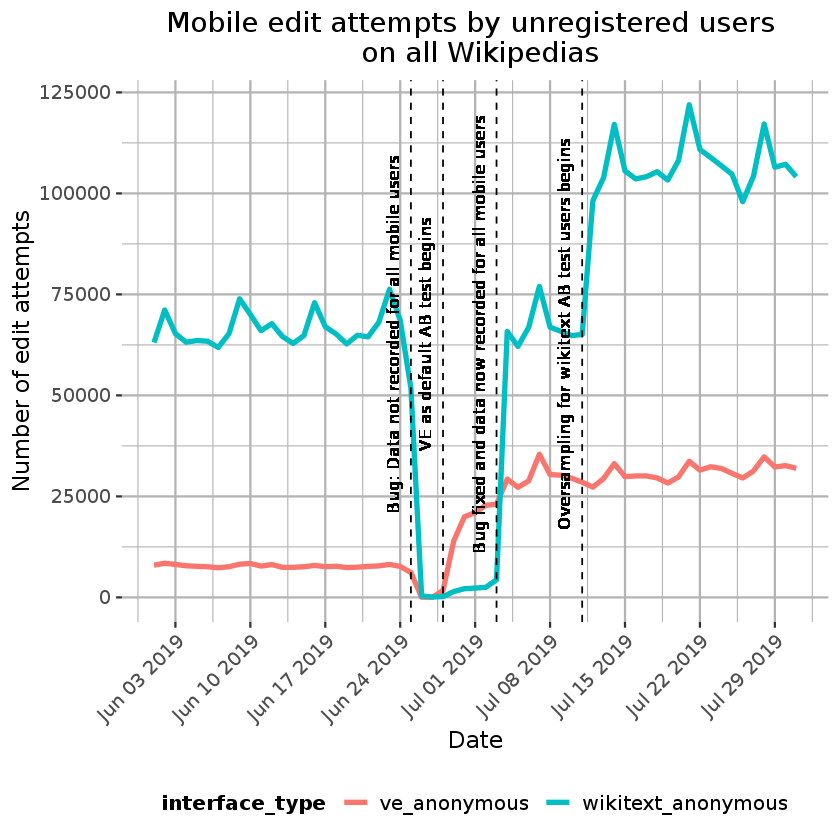

In [308]:
p <- edit_attempts_byinterface %>%
    filter(date < '2019-08-01') %>% # filter to June and July to focus on months where changes occured
 gather(interface_type, edit_attempts, 2:5) %>%
filter(interface_type %in% c('ve_anonymous', 'wikitext_anonymous')) %>%
ggplot(aes(x= date, y = edit_attempts, color = interface_type)) +    
  geom_line(size = 1.5) +
  geom_vline(xintercept = c(as.Date('2019-06-25'), as.Date('2019-07-11'), as.Date('2019-06-28'), as.Date('2019-07-03')),
             linetype = "dashed", color = "black") +        
   geom_text(aes(x=as.Date('2019-06-25'), y=6.5E4, label="Bug: Data not recorded for all mobile users"), size=3.6, vjust = -1, angle = 90, color = "black") +
   geom_text(aes(x=as.Date('2019-06-28'), y=6.5E4, label="VE as default AB test begins"), size=3.6, vjust = -1, angle = 90, color = "black") +
   geom_text(aes(x=as.Date('2019-07-03'), y=6.5E4, label="Bug fixed and data now recorded for all mobile users"), size=3.6, vjust = -1, angle = 90, color = "black") +
   geom_text(aes(x=as.Date('2019-07-11'), y=6.5E4, label="Oversampling for wikitext AB test users begins"), size=3.6, vjust = -1, angle = 90, color = "black") +
   
  scale_y_continuous("Number of edit attempts") +
  scale_x_date("Date", labels = date_format("%b %d %Y"), date_breaks = "1 week") +
  labs(title = "Mobile edit attempts by unregistered users \n on all Wikipedias") +
  ggthemes::theme_tufte(base_size = 14, base_family = "Gill Sans") +
    theme(axis.text.x=element_text(angle = 45, hjust = 1),
        plot.title = element_text(hjust = 0.5),
        panel.grid = element_line("gray70"),
        legend.position = "bottom",
        legend.title  = element_text(size=12, face = 'bold'),
        legend.text = element_text(size=12)
    )
p

ggsave("Figures/mobile_edit_attempts_unregistered.png", p, dpi = 150)



We stopped logging events for some mobile users not included in the AB test from June 25th through July 3rd due to the following bug: https://phabricator.wikimedia.org/T221197#5305019. When reviwing edit completion rates, we removed this data; but I included in back in so we can more accurately see where the drops and increases around this timeframe are occuring.

Unfortunately this is around the same time the VE AB test result is launched; however, since VE default users were not impacted by the bug you can see a signficant increase in attempts by unregistered users following the VE AB launch date. 

There was also increase in wikitext attempts as well but this is due to oversampling of mobile wikitext EditAttemptStep events on A/B test wikis on July 11th and not due to the VE as Default test.  https://phabricator.wikimedia.org/T227317.


I also did a quick comparison to registered users to see if there were any changes there.

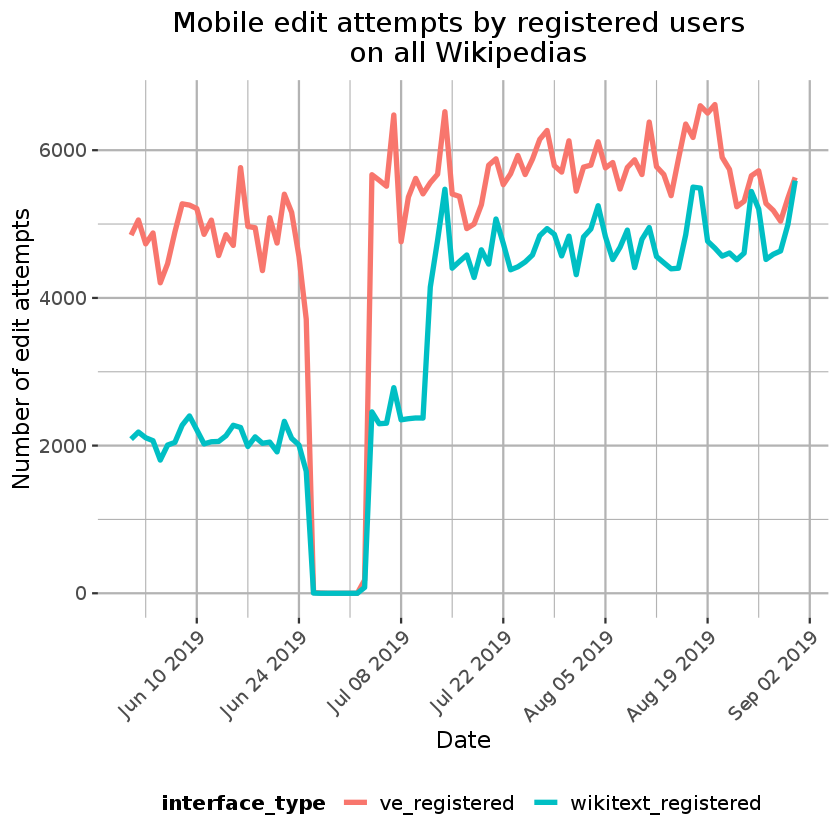

In [246]:
p <- edit_attempts_byinterface  %>%
 gather(interface_type, edit_attempts, 2:5) %>%
filter(interface_type %in% c('ve_registered', 'wikitext_registered')) %>%
ggplot(aes(x= date, y = edit_attempts, color = interface_type)) +    
  geom_line(size = 1.5) +
  scale_y_continuous("Number of edit attempts") +
  scale_x_date("Date", labels = date_format("%b %d %Y"), date_breaks = "2 weeks") +
  labs(title = "Mobile edit attempts by registered users \n on all Wikipedias") +
  ggthemes::theme_tufte(base_size = 14, base_family = "Gill Sans") +
    theme(axis.text.x=element_text(angle = 45, hjust = 1),
        plot.title = element_text(hjust = 0.5),
        panel.grid = element_line("gray70"),
        legend.position = "bottom",
        legend.title  = element_text(size=12, face = 'bold'),
        legend.text = element_text(size=12)
    )
p

There is less of a signficant change in the number of attempts by registered users on Visual Editor.

The increase in wikitext is due to the increase in sampling rate on July 11th.

Next, I'll look to see if there are any changes for unregistered users not included in the AB test. 

In [68]:
query <- 
"with attempts as (
    SELECT
        to_date(min(dt)) as date,
        sum(cast(event.editor_interface = 'visualeditor' and event.user_id != 0 as int)) as ve_registered,
        sum(cast(event.editor_interface = 'visualeditor' and event.user_id = 0 as int)) as ve_anonymous,
        sum(cast(event.editor_interface = 'wikitext' and event.user_id != 0 as int)) as wikitext_registered,
        sum(cast(event.editor_interface = 'wikitext' and event.user_id = 0 as int)) as wikitext_anonymous
    FROM event_sanitized.editattemptstep
        LEFT JOIN canonical_data.wikis 
        on wiki = database_code and
        database_group ==  'wikipedia'
    WHERE
        event.platform = 'phone' and
-- remove events not needed to calculate attemp sessions.
        event.action = 'ready' and 
--limit to only those in the VE AB default test
        event.bucket IS NULL and
        year = 2019 and (month >= 06 and month <=08)
    GROUP BY event.editing_session_id
)
SELECT
    date,
    sum(cast(ve_registered as int)) as ve_registered,
    sum(cast(ve_anonymous as int)) as ve_anonymous,
    sum(cast(wikitext_registered as int)) as wikitext_registered,
    sum(cast(wikitext_anonymous as int)) as wikitext_anonymous
FROM attempts
GROUP BY date"

In [69]:
edit_attempts_excl_ab_test <- wmf::query_hive(query)

In [70]:
edit_attempts_excl_ab_test$date <- as.Date(edit_attempts_excl_ab_test$date, format = "%Y-%m-%d")

In [71]:
#Remove bad data due to https://phabricator.wikimedia.org/T221197#5305019

edit_attempts_excl_ab_test_clean <- edit_attempts_excl_ab_test %>%
subset(date < "2019-06-26" | date > "2019-07-03")

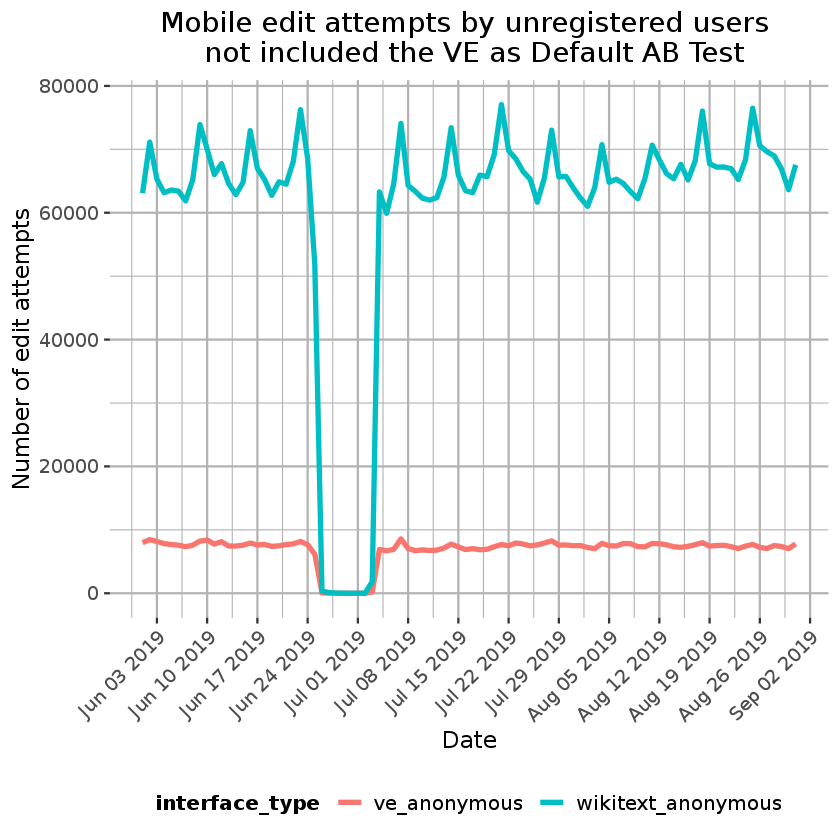

In [249]:
p <- edit_attempts_excl_ab_test %>%
 gather(interface_type, edit_attempts, 2:5) %>%
filter(interface_type %in% c('ve_anonymous', 'wikitext_anonymous')) %>%
ggplot(aes(x= date, y = edit_attempts, color = interface_type)) +    
  geom_line(size = 1.5) +
  scale_y_continuous("Number of edit attempts") +
  scale_x_date("Date", labels = date_format("%b %d %Y"), date_breaks = "1 week") +
  labs(title = "Mobile edit attempts by unregistered users \n not included the VE as Default AB Test") +
  ggthemes::theme_tufte(base_size = 14, base_family = "Gill Sans") +
    theme(axis.text.x=element_text(angle = 45, hjust = 1),
        plot.title = element_text(hjust = 0.5),
        panel.grid = element_line("gray70"),
        legend.position = "bottom",
        legend.title  = element_text(size=12, face = 'bold'),
        legend.text = element_text(size=12)
    )
p

When you remove users included in the AB test, the rate of edits attempts by unregistered users remains fairly stable. You would also expect to see a decrease after the VE ab test is deployed becasue we're removing users included in the bucket. This might be due to the change in sampling rate that also occured around the same timeframe. 

# Compare Edit Completion Rates for wikitext and VE on mobile

In [251]:
query <- 
"with attempts as (
    select
        to_date(min(dt)) as date,
        event.editor_interface as interface_type,
        sum(cast(event.action = 'saveSuccess' as int)) >= 1 as completed
    from event_sanitized.editattemptstep
    inner join canonical_data.wikis 
    on wiki = database_code and
    database_group ==  'wikipedia'
    where
        event.platform = 'phone' and
        event.user_id = 0 and
        event.action in ('ready', 'saveSuccess') and
        year = 2019 and (month >= 06 and month <=08)  
    group by event.editing_session_id, event.editor_interface
)
select
    date,
    interface_type,
    sum(cast(completed as int)) / count(*) as edit_completion
from attempts
group by date, interface_type"

In [252]:
edit_completion_rates <- wmf::query_hive(query)

In [253]:
edit_completion_rates$date <- as.Date(edit_completion_rates$date, format = "%Y-%m-%d")

In [99]:
#Remove bad data due to https://phabricator.wikimedia.org/T221197#5305019

edit_completion_rates_clean <- edit_completion_rates %>%
subset(date < "2019-06-26" | date > "2019-07-03")

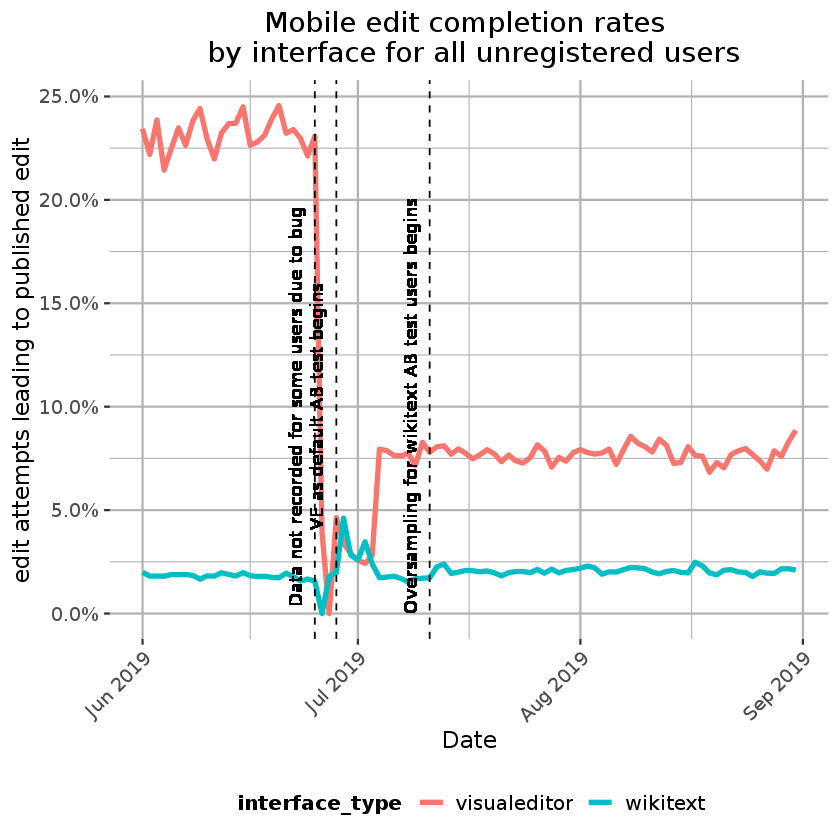

In [254]:
p <- edit_completion_rates %>%
    ggplot(aes(x= date, y = edit_completion, color = interface_type)) +    
  geom_line(size = 1.5) +
 geom_vline(xintercept = c(as.Date('2019-06-25'), as.Date('2019-07-11'), as.Date('2019-06-28')),
             linetype = "dashed", color = "black") +        
   geom_text(aes(x=as.Date('2019-06-25'), y=.10, label="Data not recorded for some users due to bug"), size=3.7, vjust = -1, angle = 90, color = "black") +
   geom_text(aes(x=as.Date('2019-06-28'), y=.10, label="VE as default AB test begins"), size=3.7, vjust = -1, angle = 90, color = "black") +
   geom_text(aes(x=as.Date('2019-07-11'), y=.10, label="Oversampling for wikitext AB test users begins"), size=3.7, vjust = -1, angle = 90, color = "black") +
  scale_y_continuous("edit attempts leading to published edit", labels = scales::percent) +
  scale_x_date("Date", labels = date_format("%b %Y"), date_breaks = "1 month") +
  labs(title = "Mobile edit completion rates \n by interface for all unregistered users") +
  ggthemes::theme_tufte(base_size = 14, base_family = "Gill Sans") +
    theme(axis.text.x=element_text(angle = 45, hjust = 1),
        plot.title = element_text(hjust = 0.5),
        panel.grid = element_line("gray70"),
         legend.position = 'bottom',
        legend.title  = element_text(size=12, face = 'bold'),
        legend.text = element_text(size=12))
p

The mobile edit completion rate dips around the time we stopped logging events due to bug for both visualeditor and wikitext. However, visual editor completion rates do not increase back to original levels once we start recording data. They stay less than half the orgiinal rates while wikitext edit completion rates remain roughly the same.

# Mobile completion rates for those not included in the AB test

In [255]:
query <- 
"with attempts as (
    select
        to_date(min(dt)) as date,
        event.editor_interface as interface_type,
        sum(cast(event.action = 'saveSuccess' as int)) >= 1 as completed
    from event_sanitized.editattemptstep
    inner join canonical_data.wikis 
    on wiki = database_code and
    database_group ==  'wikipedia'
    where
        event.platform = 'phone' and
        event.user_id = 0 and
        --limit to only those not included in the AB test/
        event.bucket is NULL and
        event.action in ('ready', 'saveSuccess') and
        year = 2019 and (month >= 06 and month <=08)  
    group by event.editing_session_id, event.editor_interface
)
select
    date,
    interface_type,
    sum(cast(completed as int)) / count(*) as edit_completion
from attempts
group by date, interface_type"



In [256]:
edit_completion_rates_excl_AB_test <- wmf::query_hive(query)

In [257]:
edit_completion_rates_excl_AB_test$date <- as.Date(edit_completion_rates_excl_AB_test$date, format = "%Y-%m-%d")

In [259]:
#Remove bad data due to https://phabricator.wikimedia.org/T221197#5305019

edit_completion_rates_excl_AB_test_clean <- edit_completion_rates_excl_AB_test %>%
subset(date < "2019-06-26" | date > "2019-07-03")

Saving 6.67 x 6.67 in image


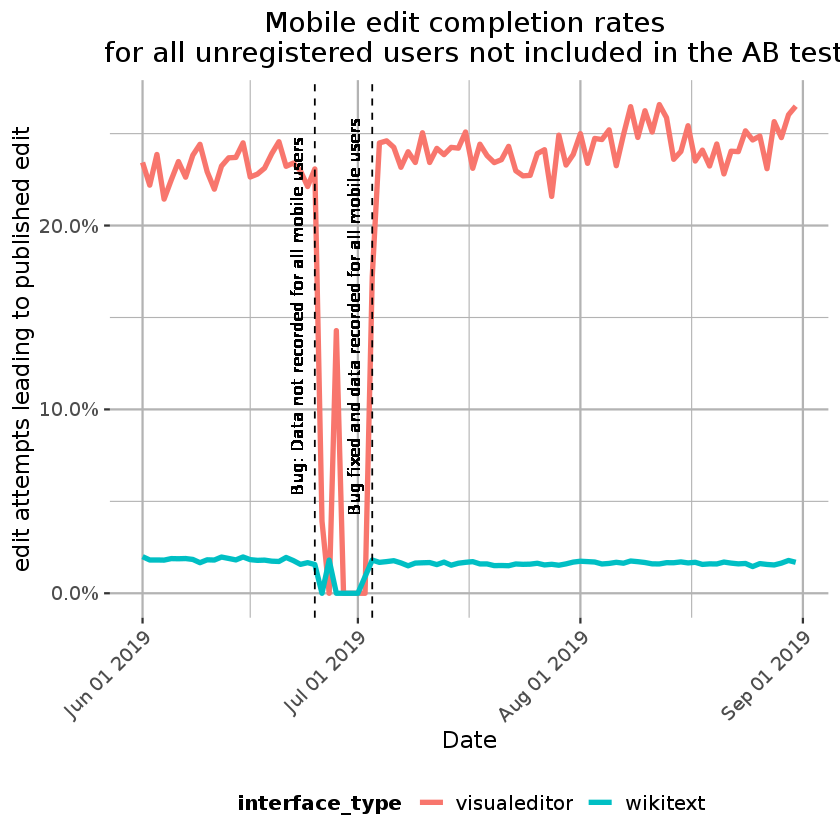

In [311]:
p <- edit_completion_rates_excl_AB_test %>%
    ggplot(aes(x= date, y = edit_completion, color = interface_type)) +    
  geom_line(size = 1.5) +
  geom_vline(xintercept = c(as.Date('2019-06-25'),as.Date('2019-07-03')),
             linetype = "dashed", color = "black") +        
   geom_text(aes(x=as.Date('2019-06-25'), y=.15, label="Bug: Data not recorded for all mobile users"), size=3.6, vjust = -1, angle = 90, color = "black") +
   geom_text(aes(x=as.Date('2019-07-03'), y=.15, label="Bug fixed and data recorded for all mobile users"), size=3.6, vjust = -1, angle = 90, color = "black") +
  scale_y_continuous("edit attempts leading to published edit", labels = scales::percent) +
  scale_x_date("Date", labels = date_format("%b %d %Y"), date_breaks = "1 month") +
  labs(title = "Mobile edit completion rates \n for all unregistered users not included in the AB test") +
  ggthemes::theme_tufte(base_size = 14, base_family = "Gill Sans") +
    theme(axis.text.x=element_text(angle = 45, hjust = 1),
        plot.title = element_text(hjust = 0.5),
        panel.grid = element_line("gray70"),
         legend.position = 'bottom',
        legend.title  = element_text(size=12, face = 'bold'),
        legend.text = element_text(size=12))
p


ggsave("Figures/mobile_edit_completes_unregistered_nonAB.png", p, dpi = 150)

When you exclude VE AB test users, the number of mobile VE attempts increases back to original levels indicating that the impact is isolated to just those included in teh AB test. 

# Edits by Action Type

Look at per action rates around that time  to see if there are any changes.

In [186]:
query <- " SELECT
        to_date(dt) as date,
        event.action as action_type,
        event.editor_interface as interface_type,
        COUNT(DISTINCT event.editing_session_id) as n_attempts
    FROM event_sanitized.editattemptstep
        LEFT JOIN canonical_data.wikis 
        on wiki = database_code and
        database_group ==  'wikipedia'
    WHERE
        event.platform = 'phone' and
        event.user_id = 0 and
        year = 2019 and (month >= 06 and month <=08)
    GROUP BY to_date(dt), event.editor_interface, event.action"

In [187]:
mobile_web_edits_byaction <- wmf::query_hive(query)

In [188]:
mobile_web_edits_byaction$date <- as.Date(mobile_web_edits_byaction$date, format = "%Y-%m-%d")

In [190]:
head(mobile_web_edits_byaction)

date,action,interface_type,n_sessions
<date>,<chr>,<chr>,<int>
2019-06-01,abort,visualeditor,3276
2019-06-01,init,visualeditor,9769
2019-06-05,abort,wikitext,47263
2019-06-05,init,wikitext,63645
2019-06-08,saveFailure,visualeditor,281
2019-06-08,saveIntent,wikitext,1386


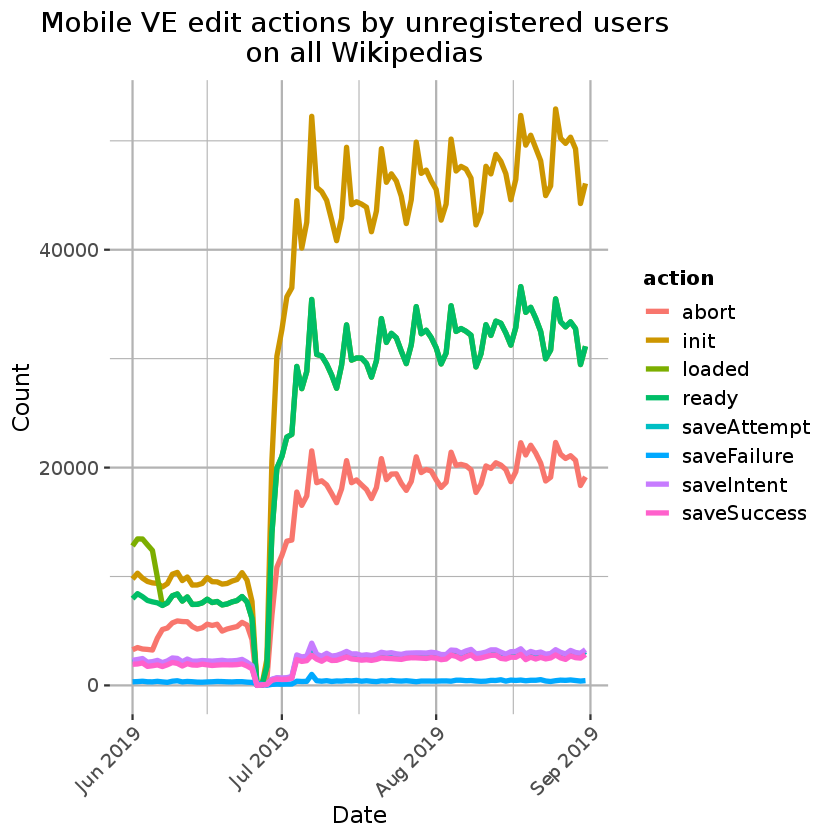

In [266]:
# Plot visual editor mobile web edits
p <- mobile_web_edits_byaction %>%
    filter(interface_type == 'visualeditor') %>%
 ggplot(aes(x= date, y = n_sessions, color = action)) +    
  geom_line(size = 1.5) +
  scale_y_continuous("Count") +
  scale_x_date("Date", labels = date_format("%b %Y"), date_breaks = "1 month") +
  labs(title = "Mobile VE edit actions by unregistered users \n on all Wikipedias") +
  ggthemes::theme_tufte(base_size = 14, base_family = "Gill Sans") +
    theme(axis.text.x=element_text(angle = 45, hjust = 1),
        plot.title = element_text(hjust = 0.5),
        panel.grid = element_line("gray70"),
         legend.position = 'right',
        legend.title  = element_text(size=12, face = 'bold'),
        legend.text = element_text(size=12))
p


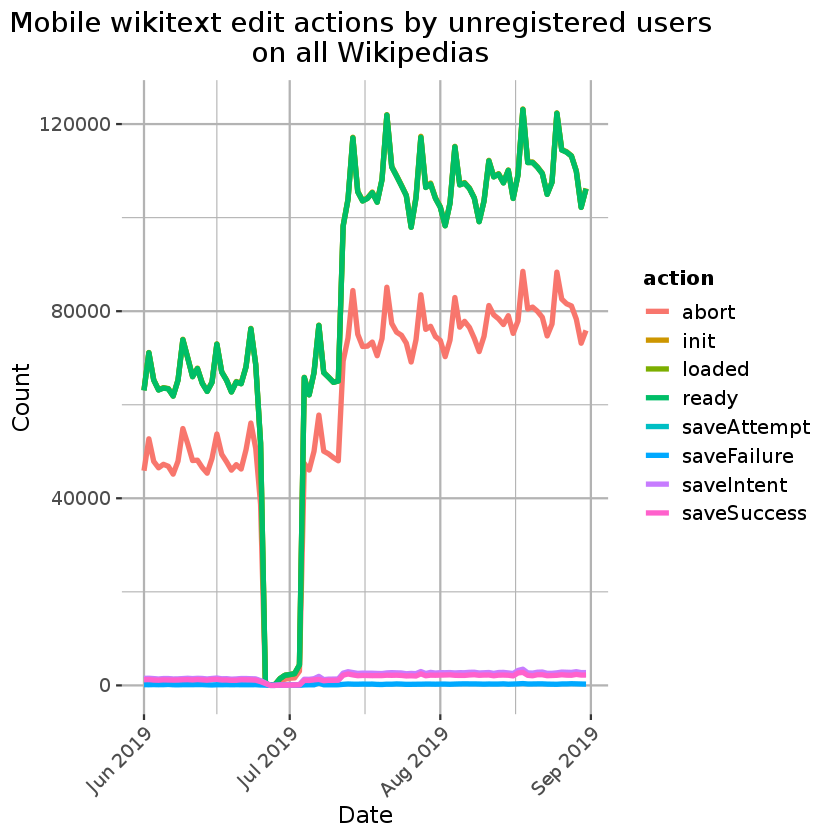

In [267]:
# Plot wikitext mobile web edits. 
p <- mobile_web_edits_byaction %>%
    filter(interface_type == 'wikitext') %>%
 ggplot(aes(x= date, y = n_sessions, color = action)) +    
  geom_line(size = 1.5) +
  scale_y_continuous("Count") +
  scale_x_date("Date", labels = date_format("%b %Y"), date_breaks = "1 month") +
  labs(title = "Mobile wikitext edit actions by unregistered users \n on all Wikipedias") +
  ggthemes::theme_tufte(base_size = 14, base_family = "Gill Sans") +
    theme(axis.text.x=element_text(angle = 45, hjust = 1),
        plot.title = element_text(hjust = 0.5),
        panel.grid = element_line("gray70"),
         legend.position = 'right',
        legend.title  = element_text(size=12, face = 'bold'),
        legend.text = element_text(size=12))
p

Note: Init amd ready are almost exactly the same so you don't see a difference in the above chart.

Review event actions for registered users only

In [213]:
query <- " SELECT
        to_date(dt) as date,
        event.action as action_type,
        event.editor_interface as interface_type,
        COUNT(DISTINCT event.editing_session_id) as n_attempts
    FROM event_sanitized.editattemptstep
        LEFT JOIN canonical_data.wikis 
        on wiki = database_code and
        database_group ==  'wikipedia'
    WHERE
        event.platform = 'phone' and
        event.user_id != 0 and
        year = 2019 and (month >= 06 and month <=08)
    GROUP BY to_date(dt), event.editor_interface, event.action"

In [214]:
mobile_web_edits_byaction_reg <- wmf::query_hive(query)

In [215]:
mobile_web_edits_byaction_reg$date <- as.Date(mobile_web_edits_byaction_reg$date, format = "%Y-%m-%d")

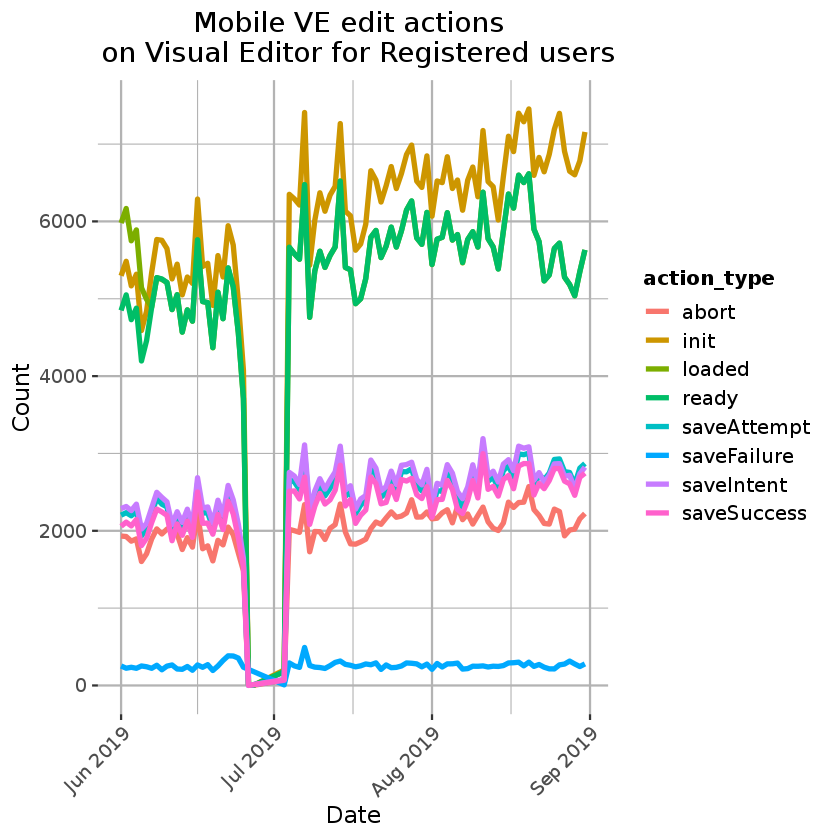

In [219]:
# Plot visual editor mobile web edits
p <- mobile_web_edits_byaction_reg %>%
    filter(interface_type == 'visualeditor') %>%
 ggplot(aes(x= date, y = n_attempts, color = action_type)) +    
  geom_line(size = 1.5) +
  scale_y_continuous("Count") +
  scale_x_date("Date", labels = date_format("%b %Y"), date_breaks = "1 month") +
  labs(title = "Mobile VE edit actions \n on Visual Editor for Registered users") +
  ggthemes::theme_tufte(base_size = 14, base_family = "Gill Sans") +
    theme(axis.text.x=element_text(angle = 45, hjust = 1),
        plot.title = element_text(hjust = 0.5),
        panel.grid = element_line("gray70"),
         legend.position = 'right',
        legend.title  = element_text(size=12, face = 'bold'),
        legend.text = element_text(size=12))
p